In [1]:
import sys
import os
sys.path.append("../..")

from progressbar import progressbar as pbar
from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from sdofm.models import vitencoder
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [3]:
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 2,
    num_workers = 15,
    num_frames  = 2,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = '2010-01-01',
    end_date   = '2011-12-31',
    dim = False,
    sampling_period = '10days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()


[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [4]:
im = torch.rand((4,9,512,512))

In [5]:
from timm.models.vision_transformer import Block, PatchEmbed


In [4]:
class TimedeltaMLP(nn.Module):
    def __init__(self, encoding_size):
        super().__init__()
        self.fc1 = nn.Linear(encoding_size*2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128,1)
        

    def forward(self, x):        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class AssembledModel(nn.Module):
    
    def __init__(self, concat_patches_size, encoder_class, **encoder_kwargs):
        super().__init__()
        self.concat_patches_size = concat_patches_size
        self.encoder         = encoder_class(**encoder_kwargs)
        self.timedelta_model = TimedeltaMLP(concat_patches_size)
        
    def forward(self, x1, x2):

        x1 = self.encoder(x1).reshape(len(x1), -1)
        x2 = self.encoder(x2).reshape(len(x2), -1)
        x = torch.concat([x1, x2], dim=1)
        x = self.timedelta_model(x)
        
        return x

In [16]:
model = AssembledModel(concat_patches_size = 16640//2, encoder_class = vitencoder.ViT2DEncoder, img_size=512, in_chans=1, embed_dim=128, patch_size=64)

In [17]:
x = torch.rand(4,1,512,512)
o = model.encoder(x)
o.shape

torch.Size([4, 65, 128])

In [18]:
model(x, x)

tensor([[-0.0254],
        [-0.0382],
        [-0.0440],
        [-0.0435]], grad_fn=<AddmmBackward0>)

In [19]:
1

1

In [20]:
psize = [np.prod(i.shape) for i in model.encoder.parameters()]
print ("encoder parameters        ", sum(psize))

psize = [np.prod(i.shape) for i in model.timedelta_model.parameters()]
print ("timedelta model parameters", sum(psize))

psize = [np.prod(i.shape) for i in model.parameters()]
print ("model total parameters    ", sum(psize))

encoder parameters         5291648
timedelta model parameters 8585985
model total parameters     13877633


In [21]:
1

1

## build dataloader objects

In [25]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

(21702, 2429)

## send models to cuda and init optimizer

In [23]:
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

## training loop

In [26]:
et = ElapsedTimes()
num_epochs = 100
lossh, lossvalh = [], []
predictions, targets = [], []
for epoch in range(num_epochs):
    t0 = datetime.now() 

    for step, batch in enumerate(dltrain):
        # extract data from batch
        with et("batch"):
            n = len(batch['image_stack'])
            
            # assumes two timeframes, compute actual time between both timeframes and scales it
            # wrt to the sampling period so that it is in [0,1]
            t = batch['timestamps']
            tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                          for ni in range(n)])\
                                       .reshape(-1,1)\
                                       .cuda()

            image_stack_t0 = batch['image_stack'][:,:1,0,:,:].cuda()
            image_stack_t1 = batch['image_stack'][:,:1,1,:,:].cuda()
            #image_stack_t0 = batch['image_stack'][:,channel_idx:channel_idx+1,0,:,:].cuda()
            #image_stack_t1 = batch['image_stack'][:,channel_idx:channel_idx+1,1,:,:].cuda()

        # run model
        with et("forward"):
            
            tdeltas_pred = model(image_stack_t0, image_stack_t1)

        # compute loss
        with et("loss"):
            loss = loss_fn(tdeltas_pred,tdeltas_truth)

        # backpropage and sigmoidupdate
        with et("backward"):
            loss.backward()
            optimizer.step()
            
            
        for p in tdeltas_pred:
            predictions.append(p)
            
        for t in tdeltas_truth:
            targets.append(t)
            
            
        with et("validation"):
            """
            # measure on val every 10 steps
            if step%10 == 0:
                try:
                    val_batch = next(val_iter)        
                except Exception as e:
                    val_iter = iter(dlval)                
                    val_batch = next(val_iter)        

                xval = batch['dimmed_image_stack'].type(torch.float)[:,:,0,:,:].cuda() # ignore time frames, just get the first one
                fval = batch['dim_factor'].type(torch.float).cuda()
                with torch.no_grad():
                    oval = model(x)
                    lossval = loss_fn(f,o)

                    lossvaln = lossval.detach().cpu().numpy()
            """
            lossvaln = 0.
        with et("logging"):
            # cosmetics
            lossn = loss.detach().cpu().numpy()
            lossh.append(lossn)

            lossvalh.append(lossvaln)


            psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
            lossm = np.mean(lossh[-100:])
            lossvalm = np.mean(lossvalh[-100:])
            epoch_time = (datetime.now() - t0).seconds
            print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} lossval {lossvalm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

    print()

KeyboardInterrupt: 

In [18]:
1

1

58.9144651889801

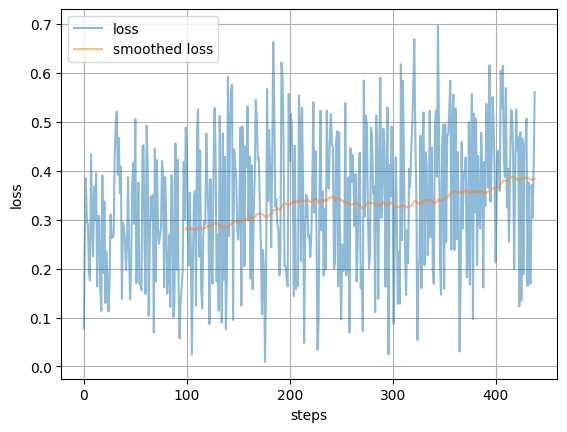

In [27]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        
ploth(lossh)
sum(list(et.elapsed_times.values()))

In [20]:
ntargets = torch.tensor(targets).cpu().numpy()+1e-5
npredictions = torch.tensor(predictions).cpu().numpy() + 1e-5

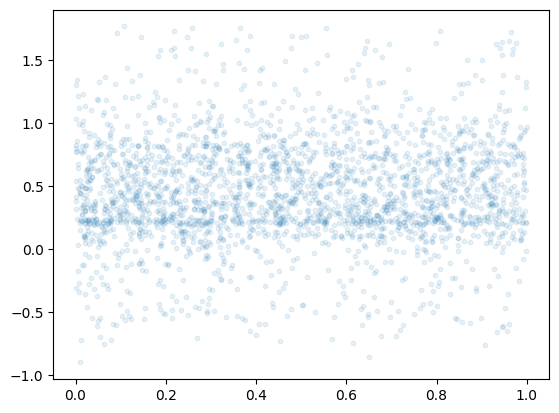

In [21]:
plt.scatter(ntargets, npredictions, alpha=0.1, s=10)

In [17]:
enc = enc.cuda()

NameError: name 'enc' is not defined

In [14]:
im = im.cuda()

In [15]:
o = enc.encoder(im)[:,0,:]
o.shape

torch.Size([4, 128])

In [16]:
o = enc(im, im)

In [17]:
o

tensor([[0.0603],
        [0.0596],
        [0.0615],
        [0.0586]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [81]:
1

1